
<center>
<font color="cyan"><h2 > Streaming</h2></font>
<center>
<h3>Stream State</h3>
<h3>Stream Token from LLM</h3>
</center>
</center>



### Summarize of chat using ChatGPT

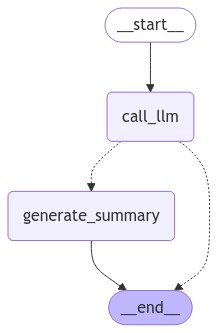

In [49]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START,END,StateGraph,MessagesState
from dotenv import load_dotenv
from IPython.display import display,Image
# import sqlite3
# from langgraph.checkpoint.sqlite import SqliteSaver
# path = 'summarize.db'
# conm = sqlite3.connect(path,check_same_thread=False)
# memory = SqliteSaver(conm)
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
load_dotenv()

llm = ChatOpenAI(model='gpt-4o-mini')

class State(MessagesState):
    summary : str
    
    
def call_llm(state):
    response = llm.invoke(state['messages'])
    return {'messages' : response}

def generate_summary(state):
    prev_summary = state.get('summary','')
    if prev_summary:
        summary = f"This is the previous summary {prev_summary}. Update the summary with the latest chat."
    else:
        summary = "Create the summary of the previous chat."
    message = state['messages']+[HumanMessage(content=summary)]
    response = llm.invoke(message)
    return {'summary': response.content,'messages':state['messages']}

def conditional_call(state):
    if len(state['messages']) > 3:
        return 'generate_summary'
    return END


builder = StateGraph(State)

builder.add_node('call_llm',call_llm)
builder.add_node('generate_summary',generate_summary)

builder.add_edge(START,'call_llm')
builder.add_conditional_edges('call_llm',conditional_call)
builder.add_edge('generate_summary',END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [7]:
config = {'configurable':{'thread_id':1}}
response = graph.invoke({'messages':"Hey I name is aditya."},config=config)

In [8]:
response

{'messages': [HumanMessage(content='Hey I name is aditya.', additional_kwargs={}, response_metadata={}, id='942f4d64-5874-46b5-86f2-f0db621e0827'),
  HumanMessage(content='Hey I name is aditya.', additional_kwargs={}, response_metadata={}, id='f45fa66e-baab-49d9-a915-28beb2e443a2'),
  AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 25, 'total_tokens': 36, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-79b9ba26-2cdc-464c-a7ab-c4b2d0e39a15-0', usage_metadata={'input_tokens': 25, 'output_tokens': 11, 'total_tokens': 36, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output

In [9]:
graph.invoke({'messages':"What is my name"},config=config)

{'messages': [HumanMessage(content='Hey I name is aditya.', additional_kwargs={}, response_metadata={}, id='942f4d64-5874-46b5-86f2-f0db621e0827'),
  HumanMessage(content='Hey I name is aditya.', additional_kwargs={}, response_metadata={}, id='f45fa66e-baab-49d9-a915-28beb2e443a2'),
  AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 25, 'total_tokens': 36, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'stop', 'logprobs': None}, id='run-79b9ba26-2cdc-464c-a7ab-c4b2d0e39a15-0', usage_metadata={'input_tokens': 25, 'output_tokens': 11, 'total_tokens': 36, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output

## stream and astream demo
.stream and .astream are sync and async methods for streaming back result.
Langgraph supports a few different methods for streaming back results.
<ul>
<li>values : This streams the full state of the graph after each node is called.</li>
<li>updtaes : This streams update to the state of the graph after each node is called.</li>
</ul>  

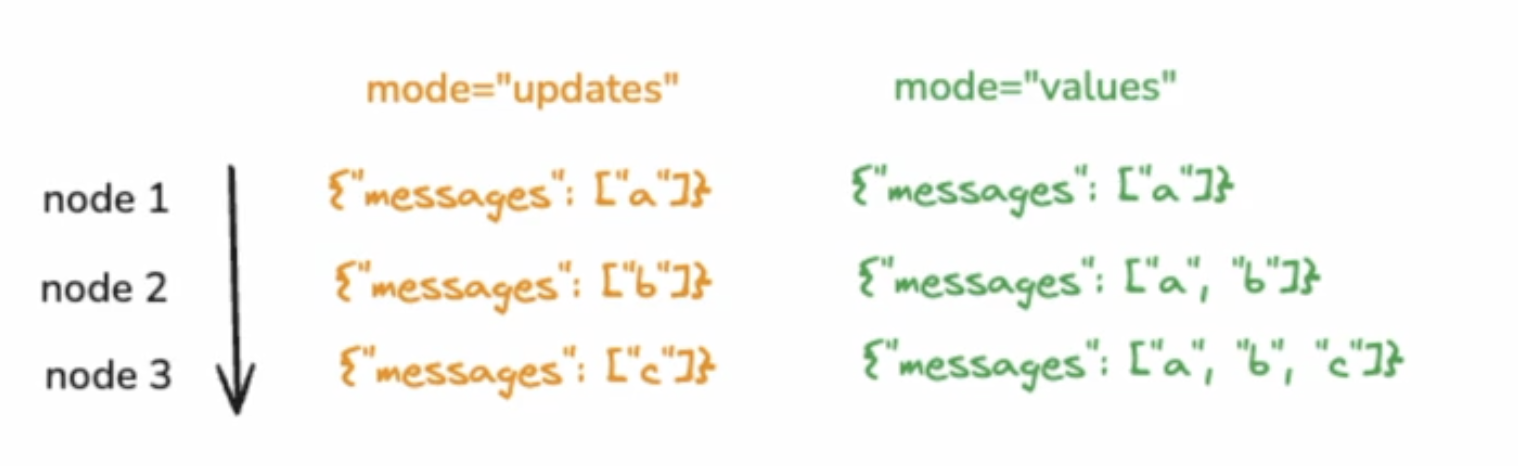

In [11]:
from IPython.display import Image

display(Image(filename="../resources/stream_values_updates.png"))

Lets look at stream_mode="updates"

<ul>
<li>
As we stream with updates, we only see updates to the state after each step of the graph.
</li>
<li>
Each chunk is a dict with node_name has the key and the updated state as the value.
</li>
</ul>

In [12]:
#create new thread id
config = {'configurable':{'thread_id':5}}
response = []
for chunk in graph.stream({'messages':[HumanMessage(content="Hey my name is Aditya")]}, config, stream_mode='updates'):
    response.append(chunk)
    print(chunk)

{'call_llm': {'messages': AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-87c82ba8-673f-4f04-a6db-288f5fb054a3-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


#### state 'messages' is updated with response in node 'call_llm'. And it is being returned here.

In [ ]:
response
for r in response:
    print(r)

{'call_llm': {'messages': AIMessage(content='Hi Aditya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 13, 'total_tokens': 24, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-87c82ba8-673f-4f04-a6db-288f5fb054a3-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [20]:
r['call_llm']['messages'].pretty_print()

================================== Ai Message ==================================

Hi Aditya! How can I assist you today?


#### stream_mode = 'values'
This is the full state of the graph after 'call_llm' is called.

In [40]:
# new thread id. As need to demonstrate stream_mode='values'
config={'configurable':{'thread_id':7}}
response_value = []
for chunk in graph.stream({'messages':[HumanMessage(content='Hey this is aditya anand')]},config=config,stream_mode='values'):
    response_value.append(chunk)
    for c in chunk['messages']:
        c.pretty_print()
    print(chunk)

================================ Human Message =================================

Hey this is aditya anand
{'messages': [HumanMessage(content='Hey this is aditya anand', additional_kwargs={}, response_metadata={}, id='cae3f04e-130b-42e2-9849-947cc1e6eda2')]}
================================ Human Message =================================

Hey this is aditya anand
================================== Ai Message ==================================

Hi Aditya Anand! How can I assist you today?
{'messages': [HumanMessage(content='Hey this is aditya anand', additional_kwargs={}, response_metadata={}, id='cae3f04e-130b-42e2-9849-947cc1e6eda2'), AIMessage(content='Hi Aditya Anand! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 14, 'total_tokens': 26, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_token

In [41]:
response_value

[{'messages': [HumanMessage(content='Hey this is aditya anand', additional_kwargs={}, response_metadata={}, id='cae3f04e-130b-42e2-9849-947cc1e6eda2')]},
 {'messages': [HumanMessage(content='Hey this is aditya anand', additional_kwargs={}, response_metadata={}, id='cae3f04e-130b-42e2-9849-947cc1e6eda2'),
   AIMessage(content='Hi Aditya Anand! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 14, 'total_tokens': 26, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-55501ace-8ccd-4f27-bb55-35f2ff999df7-0', usage_metadata={'input_tokens': 14, 'output_tokens': 12, 'total_tokens': 26, 'input_token_details': {'audio':

### Streaming Tokens
We often want to stream more than state.
In particluar, with LLM calls it is common to stream the tokens as they are generated.

<p>We can do this using the <code>.astream_events</code> method , which stream back events as they happen inside the nodes. </p>
Each event is a dict with few keys :
<ul>
<li>event : This is the type of event that is being emitted.</li>
<li>name : This is the name of the event</li>
<li>data : This is the data associated with the event.</li>
<li>metadata : Which contain langgraph_node, the node emittig the event. </li>
</ul>


In [52]:
config = {'configurable':{'thread_id':11}}
message = HumanMessage('Tell me about India.')
events = []
async for event in graph.astream_events({'messages':[message]}, config,version="v1"):
    events.append(event)
    print(event)
    print("####"*20)

{'event': 'on_chain_start', 'run_id': 'f2f8c027-e523-4116-85c7-a87b1d62d82b', 'name': 'LangGraph', 'tags': [], 'metadata': {'thread_id': 11}, 'data': {'input': {'messages': [HumanMessage(content='Tell me about India.', additional_kwargs={}, response_metadata={})]}}, 'parent_ids': []}
################################################################################
{'event': 'on_chain_start', 'name': '__start__', 'run_id': '7045a36c-06d1-4de4-b64d-6f1ae4c5a088', 'tags': ['graph:step:0', 'langsmith:hidden', 'langsmith:hidden'], 'metadata': {'thread_id': 11, 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_path': ('__pregel_pull', '__start__'), 'langgraph_checkpoint_ns': '__start__:5f67c7f9-3fb6-18d3-217e-a6d069c27d13'}, 'data': {'input': {'messages': [HumanMessage(content='Tell me about India.', additional_kwargs={}, response_metadata={})]}}, 'parent_ids': []}
###############################################################################

In [ ]:
for data in events:
    print("Node : ",data['metadata'].get('langgraph_node',''), " |  Type : ", data['event']," |  Name : ", data["name"])
    
    

Node :    |  Type :  on_chain_start  |  Name :  LangGraph
Node :  __start__  |  Type :  on_chain_start  |  Name :  __start__
Node :  __start__  |  Type :  on_chain_end  |  Name :  __start__
Node :  call_llm  |  Type :  on_chain_start  |  Name :  call_llm
Node :  call_llm  |  Type :  on_chat_model_start  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm  |  Type :  on_chat_model_stream  |  Name :  ChatOpenAI
Node :  call_llm

In [77]:
for data in events:
    if data['event'] == 'on_chain_stream':
        try: 
            print(data['data']['chunk']['messages'].pretty_print())
            print("*"*20)
        except:
            pass

================================== Ai Message ==================================

India is a country located in South Asia, known for its rich history, diverse culture, and significant geographical features. Here are some key aspects of India:

### Geography
- **Size**: India is the seventh-largest country in the world, covering approximately 3.29 million square kilometers (about 1.27 million square miles).
- **Topography**: The country features a diverse landscape, including the Himalayan mountain range in the north, vast plains, deserts (like the Thar Desert), plateaus, and a long coastline along the Indian Ocean, Arabian Sea, and Bay of Bengal.

### Population
- **Demographics**: India is the second-most populous country in the world, with over 1.4 billion people. It is home to a multitude of ethnic groups, languages, and religions.
- **Languages**: The Constitution recognizes 22 official languages, but Hindi and English are the most widely used for official and administrative purpo

In [82]:
config = {'configurable':{'thread_id':111}}
node_name_to_check_events = 'call_llm'
message = HumanMessage('Tell me about cat')
events = []
async for event in graph.astream_events({'messages':[message]}, config,version="v2"):
    events.append(event)
    if event['event'] == 'on_chat_model_stream' and event['metadata'].get('langgraph_node','') == node_name_to_check_events:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-a9fd3423-729b-44f3-b8f6-00fc0a7cfb2c')}
{'chunk': AIMessageChunk(content='Sure', additional_kwargs={}, response_metadata={}, id='run-a9fd3423-729b-44f3-b8f6-00fc0a7cfb2c')}
{'chunk': AIMessageChunk(content='!', additional_kwargs={}, response_metadata={}, id='run-a9fd3423-729b-44f3-b8f6-00fc0a7cfb2c')}
{'chunk': AIMessageChunk(content=' Here', additional_kwargs={}, response_metadata={}, id='run-a9fd3423-729b-44f3-b8f6-00fc0a7cfb2c')}
{'chunk': AIMessageChunk(content='’s', additional_kwargs={}, response_metadata={}, id='run-a9fd3423-729b-44f3-b8f6-00fc0a7cfb2c')}
{'chunk': AIMessageChunk(content=' a', additional_kwargs={}, response_metadata={}, id='run-a9fd3423-729b-44f3-b8f6-00fc0a7cfb2c')}
{'chunk': AIMessageChunk(content=' comprehensive', additional_kwargs={}, response_metadata={}, id='run-a9fd3423-729b-44f3-b8f6-00fc0a7cfb2c')}
{'chunk': AIMessageChunk(content=' overview', additional_kwargs={}, r

In [83]:
config = {'configurable':{'thread_id':1111}}
node_name_to_check_events = 'call_llm'
message = HumanMessage('Tell me about cat')
events = []
async for event in graph.astream_events({'messages':[message]}, config,version="v2"):
    events.append(event)
    if event['event'] == 'on_chat_model_stream' and event['metadata'].get('langgraph_node','') == node_name_to_check_events:
        print(event["data"]['chunk'].content , end="|")

|Cats| are| small|,| carn|iv|orous| mammals| belonging| to| the| family| Fel|idae|.| They| are| one| of| the| most| popular| pets| in| the| world|,| known| for| their| playful| and| independent| nature|.| Here| are| some| key| points| about| cats|:

|###| Biological| Characteristics|:
|-| **|Scientific| Name|**|:| The| domestic| cat| is| known| as| *|F|elis| c|atus|*|.
|-| **|Physical| Features|**|:| Cats| typically| have| a| flexible| body|,| sharp| retract|able| claws|,| and| keen| senses|,| particularly| sight| and| hearing|.
|-| **|Size|**|:| Most| domestic| cats| weigh| between| |5| to| |20| pounds|,| with| varying| breeds| exhibiting| different| sizes| and| fur| types|.

|###| Behavior|:
|-| **|Social| Structure|**|:| While| often| seen| as| solitary| animals|,| cats| can| form| strong| bonds| with| humans| and| other| pets|.| They| may| also| exhibit| social| behaviors| when| living| in| groups|.
|-| **|Terr|itorial|ity|**|:| Cats| are| territorial| creatures| and| may| mark| th